<a href="https://colab.research.google.com/github/hgene0929/deep_learning/blob/main/faster_rcnn_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


*   목표 : OpenCV DNN 패키지를 이용하여 Faster R-CNN 기반의 Object Detection 수행.
*   세부 목표 : Tensorflow 에서 Pretrained 된 모델 파일을 OpenCV에서 로드하여 이미지와 영상에 대한 Object Detection 수행.

1. 입력 이미지로 사용될 이미지 다운로드/보기

In [5]:
# 이미지를 저장하기 위한 디렉토리 생성.
!mkdir /content/data
# 이미지 파일명을 정하고, 해당 파일에 이미지 다운로드.
# 원격 저장소에서 파일 불러와야 하는 경우 wget 리눅스 명령어 사용.
# !wget -O ./data/beatles01.jpg https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg
# 로컬에 있는 저장소에서 파일 불러와야 하는 경우 직접 파일 업로드

mkdir: cannot create directory ‘/content/data’: File exists


In [ ]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

img = cv2.imread('./data/image1.jpg') # opencv 라이브러리를 통해 이미지 로딩
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # BGR -> RGB 로 변환

print('image shape:', img.shape) # 이미지 height, 이미지 width, 이미지 channel
plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

2. Tensorflow에서 Pretrained 된 Inference모델(Frozen graph)와 환경파일을 다운로드 받은 후 이를 이용해 OpenCV에서 Inference 모델 생성

- https://github.com/opencv/opencv/wiki/TensorFlow-Object-Detection-API 에 다운로드 URL 있음.
- pretrained 모델은 http://download.tensorflow.org/models/object_detection/faster_rcnn_resnet50_coco_2018_01_28.tar.gz 에서 다운로드 후 압축 해제
- pretrained 모델을 위한 환경 파일은 https://github.com/opencv/opencv_extra/blob/master/testdata/dnn/faster_rcnn_resnet50_coco_2018_01_28.pbtxt 에서 다운로드
- download된 모델 파일과 config 파일을 인자로 하여 inference 모델을 DNN에서 로딩함.

In [ ]:
!mkdir ./pretrained
# opencv에서 모델을 학습하지 않기 때문에 tensorflow에서 학습된 Frozen graph 를 다운받아 사용(weights).
!wget -O ./pretrained/faster_rcnn_resnet50_coco_2018_01_28.tar.gz http://download.tensorflow.org/models/object_detection/faster_rcnn_resnet50_coco_2018_01_28.tar.gz
# openCV에서 Frozen graph를 사용할 수 있도록 하는 설명서(config).
!wget -O ./pretrained/config_graph.pbtxt https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/faster_rcnn_resnet50_coco_2018_01_28.pbtxt

In [ ]:
# Frozen graph 압축풀기.
!tar -xvf ./pretrained/faster*.tar.gz -C ./pretrained 

In [ ]:
# Frozen graph 컨텐츠 확인.
# 사용하는 파일 : 2018 frozen_inference_graph.pb (inference용으로 데이터셋을 고정시킨 데이터).
!pwd
!ls -lia ./pretrained/faster_rcnn_resnet50_coco_2018_01_28

3. dnn에서 readNetFromTensorflow()로 tensorflow inference 모델을 로딩

In [14]:
# openCV DNN 의 readNetFromTensorflow() 함수를 통해 inference 모델 로딩.
# 파라미터 : 사용데이터모델(frozen_inference_graph.pb), 환경파일(config_graph.pbtxt)
# 결과로 openCV 네트워크 모듈이 생성됨(tensorflow로 pretrained된 모델을 학습한 object detection 네트워크).
cv_net = cv2.dnn.readNetFromTensorflow('./pretrained/faster_rcnn_resnet50_coco_2018_01_28/frozen_inference_graph.pb', './pretrained/config_graph.pbtxt')

4. coco 데이터 세트의 클래스id별 클래스명 지정

In [15]:
# OpenCV Tensorflow Faster-RCNN용
# MS COCO 데이터셋에 제대로 매핑되지 않은 레이블에 대한 처리.
labels_to_names_0 = {0:'person',1:'bicycle',2:'car',3:'motorcycle',4:'airplane',5:'bus',6:'train',7:'truck',8:'boat',9:'traffic light',
                    10:'fire hydrant',11:'street sign',12:'stop sign',13:'parking meter',14:'bench',15:'bird',16:'cat',17:'dog',18:'horse',19:'sheep',
                    20:'cow',21:'elephant',22:'bear',23:'zebra',24:'giraffe',25:'hat',26:'backpack',27:'umbrella',28:'shoe',29:'eye glasses',
                    30:'handbag',31:'tie',32:'suitcase',33:'frisbee',34:'skis',35:'snowboard',36:'sports ball',37:'kite',38:'baseball bat',39:'baseball glove',
                    40:'skateboard',41:'surfboard',42:'tennis racket',43:'bottle',44:'plate',45:'wine glass',46:'cup',47:'fork',48:'knife',49:'spoon',
                    50:'bowl',51:'banana',52:'apple',53:'sandwich',54:'orange',55:'broccoli',56:'carrot',57:'hot dog',58:'pizza',59:'donut',
                    60:'cake',61:'chair',62:'couch',63:'potted plant',64:'bed',65:'mirror',66:'dining table',67:'window',68:'desk',69:'toilet',
                    70:'door',71:'tv',72:'laptop',73:'mouse',74:'remote',75:'keyboard',76:'cell phone',77:'microwave',78:'oven',79:'toaster',
                    80:'sink',81:'refrigerator',82:'blender',83:'book',84:'clock',85:'vase',86:'scissors',87:'teddy bear',88:'hair drier',89:'toothbrush',
                    90:'hair brush'}

5. 이미지를 preprocessing 수행하여 Network에 입력하고 Object Detection 수행 후 결과를 이미지에 시각화

In [ ]:
img.shape

In [ ]:
# 원본 이미지가 Faster RCNN기반 네트웍으로 입력 시 resize됨. 
# scaling된 이미지 기반으로 bounding box 위치가 예측 되므로 이를 다시 원복하기 위해 원본 이미지 shape정보 필요
rows = img.shape[0] # 이미지의 높이(height)
cols = img.shape[1] # 이미지의 너비(width)
# cv2의 rectangle()은 인자로 들어온 이미지 배열에 직접 사각형을 업데이트 하므로 그림 표현을 위한 별도의 이미지 배열 생성. 
draw_img = img.copy() # 바운딩박스가 그려진 이미지파일을 따로 생성하기 위해 원본 이미지 복사.

# 원본 이미지 배열 BGR을 RGB로 변환하여 배열 입력. Tensorflow Faster RCNN은 마지막 classification layer가 Dense가 아니여서 size를 고정할 필요는 없음.  
cv_net.setInput(cv2.dnn.blobFromImage(img, swapRB=True, crop=False))

# Object Detection 수행하여 결과를 cvOut으로 반환 
cv_out = cv_net.forward() # inference
print(cv_out.shape)

# bounding box의 테두리와 caption 글자색 지정
green_color=(0, 255, 0)
red_color=(0, 0, 255)

# detected 된 object들을 iteration 하면서 정보 추출
for detection in cv_out[0,0,:,:]:
    score = float(detection[2])
    class_id = int(detection[1])
    # detected된 object들의 score가 0.13 이상인 동시에 분류클래스가 자동차인 것만 추출
    if score > 0.13 and class_id == 2:
        # detected된 object들은 scale된 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산
        left = detection[3] * cols
        top = detection[4] * rows
        right = detection[5] * cols
        bottom = detection[6] * rows
        # labels_to_names_seq 딕셔너리로 class_id값을 클래스명으로 변경.
        caption = "{}: {:.4f}".format(labels_to_names_0[class_id], score)
        print(caption)
        # detected 된 oobject들의 y start, y end, x start, x end 좌표값 출력
        print(bottom)
        print(top)
        print(left)
        print(right)
        #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
        cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
        cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

6. 이미지를 preprocessing 수행하여 Network에 입력하고 Object Detection 수행 후 결과를 이미지에 시각화

- 원본 이미지에 삽입할 대상 이미지에서 동일한 객체 detection 수행.

In [ ]:
img2 = cv2.imread('./data/image2.jpg') # opencv 라이브러리를 통해 이미지 로딩
img_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB) # BGR -> RGB 로 변환

print('image shape:', img2.shape) # 이미지 height, 이미지 width, 이미지 channel
plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

6. 단일 이미지의 object detection을 함수로 생성

In [37]:
import time

def get_detected_img(cv_net, img_array, score_threshold, use_copied_array=True, is_print=True):
    
    rows = img_array.shape[0]
    cols = img_array.shape[1]
    
    draw_img = None
    if use_copied_array:
        draw_img = img_array.copy()
    else:
        draw_img = img_array
    
    cv_net.setInput(cv2.dnn.blobFromImage(img_array, swapRB=True, crop=False))
    
    start = time.time()
    cv_out = cv_net.forward()
    
    green_color=(0, 255, 0)
    red_color=(0, 0, 255)

    # detected 된 object들을 iteration 하면서 정보 추출
    for detection in cv_out[0,0,:,:]:
        score = float(detection[2])
        class_id = int(detection[1])
        # detected된 object들의 score가 함수 인자로 들어온 score_threshold 이상만 추출
        if score > score_threshold:
            # detected된 object들은 scale된 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산
            left = detection[3] * cols
            top = detection[4] * rows
            right = detection[5] * cols
            bottom = detection[6] * rows
            # labels_to_names 딕셔너리로 class_id값을 클래스명으로 변경. opencv에서는 class_id + 1로 매핑해야함.
            caption = "{}: {:.4f}".format(labels_to_names_0[class_id], score)
            print(caption)
            #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
            cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
            cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)
    if is_print:
        print('Detection 수행시간:',round(time.time() - start, 2),"초")

    return draw_img

image shape: (1600, 690, 3)
person: 0.9976
person: 0.9974
person: 0.9088
person: 0.6906
Detection 수행시간: 4.86 초


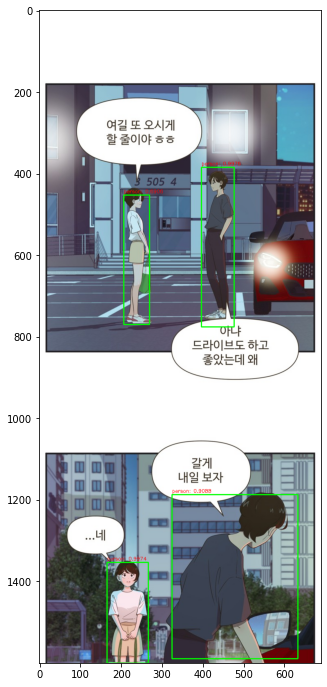

In [38]:
# image 로드 
img = cv2.imread('./data/image1.jpg')
print('image shape:', img.shape)

# tensorflow inference 모델 로딩
cv_net = cv2.dnn.readNetFromTensorflow('./pretrained/faster_rcnn_resnet50_coco_2018_01_28/frozen_inference_graph.pb', 
                                     './pretrained/config_graph.pbtxt')
# Object Detetion 수행 후 시각화 
draw_img = get_detected_img(cv_net, img, score_threshold=0.5, use_copied_array=True, is_print=True)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)